In [1]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=974821db9b6a398e818301760642d6ad842377cab3c3a48f12038f52baecb3de
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built GPUtil


In [1]:
# ViT + MaxViT Hybrid (Performance VS Optimizers)

import torch
import numpy as np
import time
import psutil
import GPUtil
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from transformers import ViTModel
import timm
from tqdm import tqdm
from torch import optim

class JetDataset(Dataset):
    def __init__(self, npz_file, train=True):
        data = np.load(npz_file)
        self.X = data['X']
        self.y = data['y']
        self.transform = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop(224, scale=(0.7, 1.0), interpolation=InterpolationMode.BILINEAR),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.3, 0.3, 0.2, 0.1),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]) if train else T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img = (self.X[idx] * 255).astype(np.uint8) if self.X[idx].dtype != np.uint8 else self.X[idx]
        return self.transform(img), torch.tensor(self.y[idx], dtype=torch.long)

class ViT_MaxViT_Hybrid(torch.nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.maxvit = timm.create_model('maxvit_base_tf_224', pretrained=True)
        for p in self.vit.parameters(): p.requires_grad = False
        for p in self.maxvit.parameters(): p.requires_grad = False
        vit_dim = self.vit.config.hidden_size
        maxvit_dim = self.maxvit.head.in_features
        self.maxvit.head = torch.nn.Identity()
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(vit_dim + maxvit_dim, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, num_classes)
        )

    def forward(self, x):
        vit_cls = self.vit(pixel_values=x).last_hidden_state[:, 0]
        max_feat = torch.mean(self.maxvit.forward_features(x), dim=[2, 3])
        return self.classifier(torch.cat((vit_cls, max_feat), dim=1))

def evaluate_model(model, val_loader, device):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Evaluating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            probs = torch.softmax(out, dim=1)[:, 1]
            preds = out.argmax(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return (
        precision_score(all_labels, all_preds),
        recall_score(all_labels, all_preds),
        f1_score(all_labels, all_preds),
        roc_auc_score(all_labels, all_probs)
    )

def test_optimizers(npz_path, device='cuda'):
    optimizers = {
        'Adam': lambda params: optim.Adam(params, lr=1e-4, weight_decay=1e-3),
        'AdamW': lambda params: optim.AdamW(params, lr=1e-4, weight_decay=1e-3),
        'SGD': lambda params: optim.SGD(params, lr=1e-4, momentum=0.9, weight_decay=1e-3),
        'RMSprop': lambda params: optim.RMSprop(params, lr=1e-4, weight_decay=1e-3),
        'Lion': lambda params: optim.AdamW(params, lr=1e-4, weight_decay=1e-3)  # Placeholder for Lion
    }

    dataset = JetDataset(npz_path, train=True)
    train_size = int(0.8 * len(dataset))
    train_set, val_set = random_split(dataset, [train_size, len(dataset) - train_size])
    train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=8, shuffle=False, num_workers=2)

    results = []

    for name, opt_fn in optimizers.items():
        torch.cuda.empty_cache()
        print(f"\n⚙️ Testing Optimizer: {name}")

        try:
            model = ViT_MaxViT_Hybrid().to(device)
            optimizer = opt_fn(filter(lambda p: p.requires_grad, model.parameters()))
            criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
            scaler = torch.cuda.amp.GradScaler()
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

            for p in model.classifier.parameters(): p.requires_grad = True

            for epoch in range(10):
                print(f"\nEpoch {epoch+1}/10")
                if epoch == 5:
                    for p in model.vit.parameters(): p.requires_grad = True
                    optimizer.add_param_group({"params": filter(lambda p: p.requires_grad, model.vit.parameters()), "lr": 1e-5})
                elif epoch == 9:
                    for p in model.maxvit.parameters(): p.requires_grad = True
                    optimizer.add_param_group({"params": filter(lambda p: p.requires_grad, model.maxvit.parameters()), "lr": 1e-5})

                model.train()
                for imgs, labels in tqdm(train_loader, desc=f"{name} - Epoch {epoch+1}", leave=False):
                    imgs, labels = imgs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    with torch.cuda.amp.autocast():
                        out = model(imgs)
                        loss = criterion(out, labels)
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                scheduler.step(epoch + 1)

                prec, rec, f1, roc = evaluate_model(model, val_loader, device)
                print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC-AUC: {roc:.4f}")

            results.append({
                'Optimizer': name,
                'Precision': prec,
                'Recall': rec,
                'F1 Score': f1,
                'ROC-AUC': roc
            })

        except RuntimeError as e:
            print(f"❌ Skipped Optimizer {name}: {str(e).splitlines()[0]}")
            torch.cuda.empty_cache()
            continue

    return pd.DataFrame(results)

df_optim = test_optimizers('/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz')
print(df_optim)


KeyboardInterrupt: 

2025-05-22 23:54:34.221827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747958074.455300      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747958074.523783      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



⚙️ Testing Optimizer: Adam


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

/tmp/ipykernel_35/2132938735.py:109: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/10


Adam - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6136, Recall: 0.5960, F1: 0.6047, ROC-AUC: 0.6394

Epoch 2/10


Adam - Epoch 2:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6307, Recall: 0.6777, F1: 0.6533, ROC-AUC: 0.6934

Epoch 3/10


Adam - Epoch 3:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.7289, Recall: 0.4814, F1: 0.5798, ROC-AUC: 0.7161

Epoch 4/10


Adam - Epoch 4:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6552, Recall: 0.7350, F1: 0.6928, ROC-AUC: 0.7283

Epoch 5/10


Adam - Epoch 5:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6601, Recall: 0.6261, F1: 0.6426, ROC-AUC: 0.7029

Epoch 6/10


Adam - Epoch 6:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6799, Recall: 0.6390, F1: 0.6588, ROC-AUC: 0.7199

Epoch 7/10


Adam - Epoch 7:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6561, Recall: 0.7106, F1: 0.6823, ROC-AUC: 0.7154

Epoch 8/10


Adam - Epoch 8:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6437, Recall: 0.6963, F1: 0.6690, ROC-AUC: 0.7138

Epoch 9/10


Adam - Epoch 9:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6855, Recall: 0.5401, F1: 0.6042, ROC-AUC: 0.7157

Epoch 10/10


Adam - Epoch 10:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.7205, Recall: 0.6203, F1: 0.6667, ROC-AUC: 0.7563

⚙️ Testing Optimizer: AdamW


/tmp/ipykernel_35/2132938735.py:109: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/10


AdamW - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6506, Recall: 0.6189, F1: 0.6344, ROC-AUC: 0.6753

Epoch 2/10


AdamW - Epoch 2:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6667, Recall: 0.6447, F1: 0.6555, ROC-AUC: 0.6981

Epoch 3/10


AdamW - Epoch 3:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6153, Recall: 0.7607, F1: 0.6803, ROC-AUC: 0.7012

Epoch 4/10


AdamW - Epoch 4:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6672, Recall: 0.5888, F1: 0.6256, ROC-AUC: 0.7010

Epoch 5/10


AdamW - Epoch 5:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6507, Recall: 0.6218, F1: 0.6359, ROC-AUC: 0.7030

Epoch 6/10


AdamW - Epoch 6:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6603, Recall: 0.6905, F1: 0.6751, ROC-AUC: 0.7095

Epoch 7/10


AdamW - Epoch 7:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.7245, Recall: 0.5387, F1: 0.6179, ROC-AUC: 0.7171

Epoch 8/10


AdamW - Epoch 8:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6729, Recall: 0.6662, F1: 0.6695, ROC-AUC: 0.7373

Epoch 9/10


AdamW - Epoch 9:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6999, Recall: 0.6948, F1: 0.6973, ROC-AUC: 0.7490

Epoch 10/10


AdamW - Epoch 10:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6425, Recall: 0.7751, F1: 0.7026, ROC-AUC: 0.7490

⚙️ Testing Optimizer: SGD


/tmp/ipykernel_35/2132938735.py:109: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/10


SGD - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6248, Recall: 0.5989, F1: 0.6116, ROC-AUC: 0.6638

Epoch 2/10


SGD - Epoch 2:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6443, Recall: 0.6461, F1: 0.6452, ROC-AUC: 0.6984

Epoch 3/10


SGD - Epoch 3:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.7127, Recall: 0.4728, F1: 0.5685, ROC-AUC: 0.7018

Epoch 4/10


SGD - Epoch 4:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6612, Recall: 0.5731, F1: 0.6140, ROC-AUC: 0.7058

Epoch 5/10


SGD - Epoch 5:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6496, Recall: 0.6562, F1: 0.6529, ROC-AUC: 0.7024

Epoch 6/10


SGD - Epoch 6:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6295, Recall: 0.6232, F1: 0.6263, ROC-AUC: 0.6773

Epoch 7/10


SGD - Epoch 7:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6672, Recall: 0.5860, F1: 0.6240, ROC-AUC: 0.6999

Epoch 8/10


SGD - Epoch 8:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6420, Recall: 0.5215, F1: 0.5755, ROC-AUC: 0.6755

Epoch 9/10


SGD - Epoch 9:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6491, Recall: 0.5458, F1: 0.5930, ROC-AUC: 0.6917

Epoch 10/10


SGD - Epoch 10:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6255, Recall: 0.6533, F1: 0.6391, ROC-AUC: 0.6860

⚙️ Testing Optimizer: RMSprop


/tmp/ipykernel_35/2132938735.py:109: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/10


RMSprop - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6208, Recall: 0.6848, F1: 0.6512, ROC-AUC: 0.6867

Epoch 2/10


RMSprop - Epoch 2:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6733, Recall: 0.4842, F1: 0.5633, ROC-AUC: 0.6915

Epoch 3/10


RMSprop - Epoch 3:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6634, Recall: 0.5759, F1: 0.6166, ROC-AUC: 0.7002

Epoch 4/10


RMSprop - Epoch 4:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6588, Recall: 0.6777, F1: 0.6681, ROC-AUC: 0.7015

Epoch 5/10


RMSprop - Epoch 5:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6760, Recall: 0.6246, F1: 0.6493, ROC-AUC: 0.7165

Epoch 6/10


RMSprop - Epoch 6:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6485, Recall: 0.6476, F1: 0.6480, ROC-AUC: 0.7005

Epoch 7/10


RMSprop - Epoch 7:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6901, Recall: 0.5616, F1: 0.6193, ROC-AUC: 0.7210

Epoch 8/10


RMSprop - Epoch 8:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6532, Recall: 0.5802, F1: 0.6146, ROC-AUC: 0.6972

Epoch 9/10


RMSprop - Epoch 9:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6446, Recall: 0.7378, F1: 0.6880, ROC-AUC: 0.7288

Epoch 10/10


RMSprop - Epoch 10:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.7438, Recall: 0.5616, F1: 0.6400, ROC-AUC: 0.7635

⚙️ Testing Optimizer: Lion


/tmp/ipykernel_35/2132938735.py:109: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/10


Lion - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6424, Recall: 0.5817, F1: 0.6105, ROC-AUC: 0.6696

Epoch 2/10


Lion - Epoch 2:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6775, Recall: 0.5659, F1: 0.6167, ROC-AUC: 0.6920

Epoch 3/10


Lion - Epoch 3:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6348, Recall: 0.7049, F1: 0.6680, ROC-AUC: 0.6903

Epoch 4/10


Lion - Epoch 4:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6787, Recall: 0.6476, F1: 0.6628, ROC-AUC: 0.7267

Epoch 5/10


Lion - Epoch 5:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6677, Recall: 0.6418, F1: 0.6545, ROC-AUC: 0.7130

Epoch 6/10


Lion - Epoch 6:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.7215, Recall: 0.4269, F1: 0.5365, ROC-AUC: 0.7172

Epoch 7/10


Lion - Epoch 7:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6578, Recall: 0.7049, F1: 0.6805, ROC-AUC: 0.7204

Epoch 8/10


Lion - Epoch 8:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6934, Recall: 0.6934, F1: 0.6934, ROC-AUC: 0.7385

Epoch 9/10


Lion - Epoch 9:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6646, Recall: 0.7550, F1: 0.7069, ROC-AUC: 0.7507

Epoch 10/10


Lion - Epoch 10:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/2132938735.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                                  

Precision: 0.7316, Recall: 0.6562, F1: 0.6918, ROC-AUC: 0.7720
  Optimizer  Precision    Recall  F1 Score   ROC-AUC
0      Adam   0.720466  0.620344  0.666667  0.756305
1     AdamW   0.642518  0.775072  0.702597  0.749032
2       SGD   0.625514  0.653295  0.639103  0.686017
3   RMSprop   0.743833  0.561605  0.640000  0.763469
4      Lion   0.731629  0.656160  0.691843  0.771976


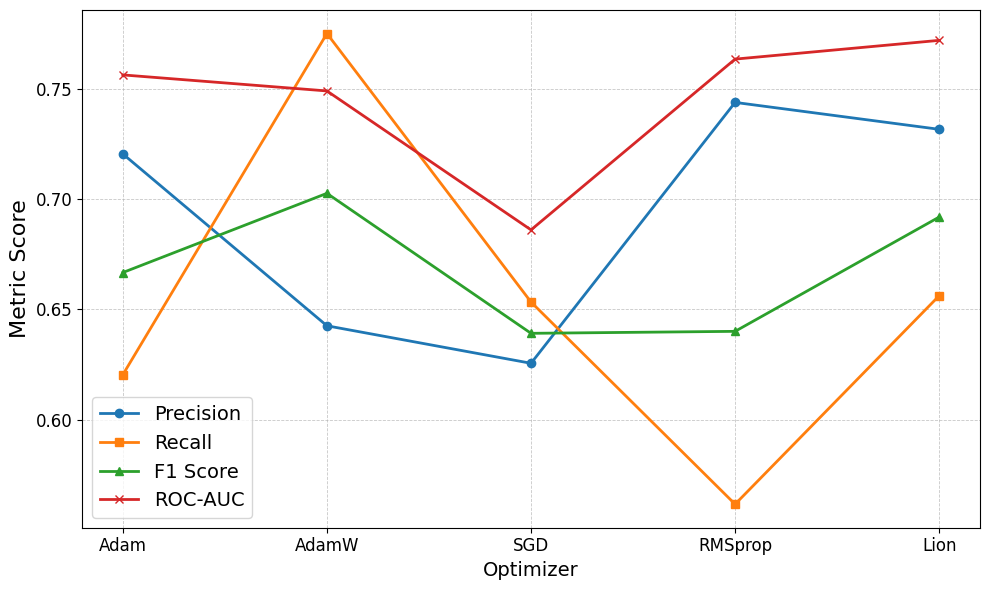

In [4]:
# ViT + MaxViT Hybrid (Performance VS Optimizers) - Chart

import matplotlib.pyplot as plt
import pandas as pd

# === Define Data ===
data = {
    'Optimizer': ['Adam', 'AdamW', 'SGD', 'RMSprop', 'Lion'],
    'Precision': [0.720466, 0.642518, 0.625514, 0.743833, 0.731629],
    'Recall': [0.620344, 0.775072, 0.653295, 0.561605, 0.656160],
    'F1 Score': [0.666667, 0.702597, 0.639103, 0.640000, 0.691843],
    'ROC-AUC': [0.756305, 0.749032, 0.686017, 0.763469, 0.771976]
}

df = pd.DataFrame(data)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(df['Optimizer'], df['Precision'], marker='o', label='Precision', linewidth=2)
plt.plot(df['Optimizer'], df['Recall'], marker='s', label='Recall', linewidth=2)
plt.plot(df['Optimizer'], df['F1 Score'], marker='^', label='F1 Score', linewidth=2)
plt.plot(df['Optimizer'], df['ROC-AUC'], marker='x', label='ROC-AUC', linewidth=2)

# === Styling for Journal ===
#plt.title('Model Performance vs Optimizer', fontsize=16, weight='bold')
plt.xlabel('Optimizer', fontsize=14)
plt.ylabel('Metric Score', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
plt.legend(loc='lower left', fontsize=14)
plt.tight_layout()
plt.savefig("optimizer_vs_performance.pdf", format='pdf', bbox_inches='tight')
plt.show()



🎯 Testing Dropout Rate: 0.2


/tmp/ipykernel_35/365881966.py:101: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/5


Dropout 0.20 - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/365881966.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.5771 | Recall: 0.7446 | F1: 0.6502 | ROC-AUC: 0.6658
CM:
[[335 376]
 [176 513]]
Epoch 2/5


Dropout 0.20 - Epoch 2:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/365881966.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6019 | Recall: 0.7286 | F1: 0.6592 | ROC-AUC: 0.6905
CM:
[[379 332]
 [187 502]]
Epoch 3/5


Dropout 0.20 - Epoch 3:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/365881966.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6433 | Recall: 0.6125 | F1: 0.6275 | ROC-AUC: 0.6915
CM:
[[477 234]
 [267 422]]
Epoch 4/5


Dropout 0.20 - Epoch 4:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/365881966.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6893 | Recall: 0.6183 | F1: 0.6519 | ROC-AUC: 0.7191
CM:
[[519 192]
 [263 426]]
Epoch 5/5


Dropout 0.20 - Epoch 5:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/365881966.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6827 | Recall: 0.6183 | F1: 0.6489 | ROC-AUC: 0.7221
CM:
[[513 198]
 [263 426]]



🎯 Testing Dropout Rate: 0.3


/tmp/ipykernel_35/365881966.py:101: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/5


Dropout 0.30 - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/365881966.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.5934 | Recall: 0.7794 | F1: 0.6738 | ROC-AUC: 0.6926
CM:
[[343 368]
 [152 537]]
Epoch 2/5


Dropout 0.30 - Epoch 2:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/365881966.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6099 | Recall: 0.7170 | F1: 0.6591 | ROC-AUC: 0.6755
CM:
[[395 316]
 [195 494]]
Epoch 3/5


Dropout 0.30 - Epoch 3:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/365881966.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6255 | Recall: 0.7126 | F1: 0.6662 | ROC-AUC: 0.6998
CM:
[[417 294]
 [198 491]]
Epoch 4/5


Dropout 0.30 - Epoch 4:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/365881966.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.5920 | Recall: 0.7518 | F1: 0.6624 | ROC-AUC: 0.6965
CM:
[[354 357]
 [171 518]]
Epoch 5/5


Dropout 0.30 - Epoch 5:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/365881966.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6541 | Recall: 0.6531 | F1: 0.6536 | ROC-AUC: 0.7192
CM:
[[473 238]
 [239 450]]



🎯 Testing Dropout Rate: 0.5


/tmp/ipykernel_35/365881966.py:101: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/5


Dropout 0.50 - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/365881966.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.5972 | Recall: 0.5486 | F1: 0.5719 | ROC-AUC: 0.6398
CM:
[[456 255]
 [311 378]]
Epoch 2/5


Dropout 0.50 - Epoch 2:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/365881966.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6561 | Recall: 0.5399 | F1: 0.5924 | ROC-AUC: 0.6798
CM:
[[516 195]
 [317 372]]
Epoch 3/5


Dropout 0.50 - Epoch 3:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/365881966.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6184 | Recall: 0.7010 | F1: 0.6571 | ROC-AUC: 0.6958
CM:
[[413 298]
 [206 483]]
Epoch 4/5


Dropout 0.50 - Epoch 4:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/365881966.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6781 | Recall: 0.5718 | F1: 0.6205 | ROC-AUC: 0.7074
CM:
[[524 187]
 [295 394]]
Epoch 5/5


Dropout 0.50 - Epoch 5:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/365881966.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6892 | Recall: 0.5922 | F1: 0.6370 | ROC-AUC: 0.7207
CM:
[[527 184]
 [281 408]]



🎯 Testing Dropout Rate: 0.7


/tmp/ipykernel_35/365881966.py:101: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/5


Dropout 0.70 - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/365881966.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6248 | Recall: 0.5341 | F1: 0.5759 | ROC-AUC: 0.6603
CM:
[[490 221]
 [321 368]]
Epoch 2/5


Dropout 0.70 - Epoch 2:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/365881966.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6581 | Recall: 0.5559 | F1: 0.6027 | ROC-AUC: 0.6816
CM:
[[512 199]
 [306 383]]
Epoch 3/5


Dropout 0.70 - Epoch 3:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/365881966.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6463 | Recall: 0.5994 | F1: 0.6220 | ROC-AUC: 0.6914
CM:
[[485 226]
 [276 413]]
Epoch 4/5


Dropout 0.70 - Epoch 4:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/365881966.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6609 | Recall: 0.6139 | F1: 0.6366 | ROC-AUC: 0.7005
CM:
[[494 217]
 [266 423]]
Epoch 5/5


Dropout 0.70 - Epoch 5:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/365881966.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6134 | Recall: 0.7417 | F1: 0.6715 | ROC-AUC: 0.7024
CM:
[[389 322]
 [178 511]]


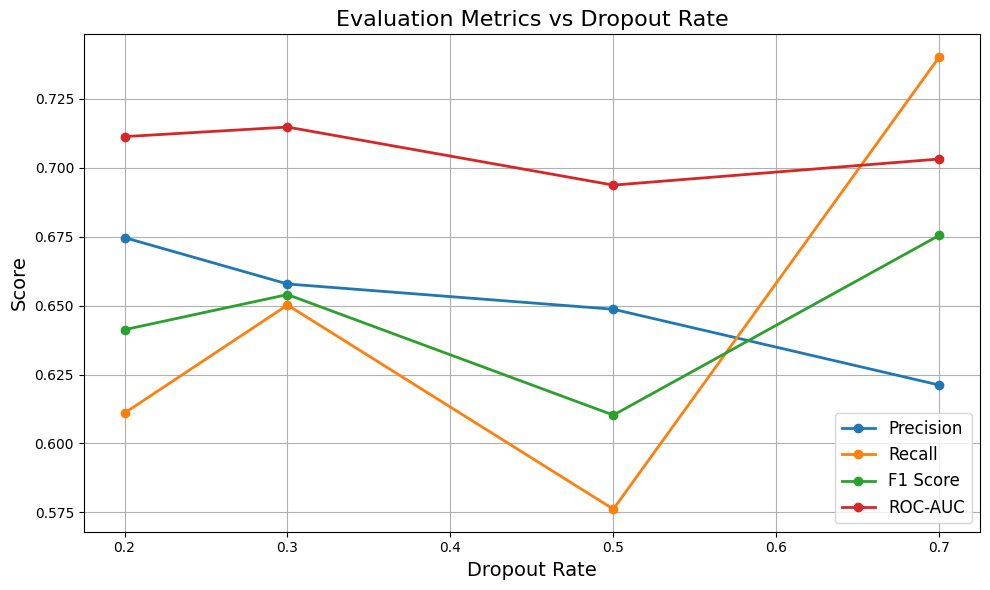

   Dropout Rate  Precision    Recall  F1 Score   ROC-AUC
0           0.2   0.674679  0.611030  0.641280  0.711306
1           0.3   0.657856  0.650218  0.654015  0.714774
2           0.5   0.648693  0.576197  0.610300  0.693714
3           0.7   0.621194  0.740203  0.675497  0.703183


In [3]:
# ViT + MaxViT Hybrid (Performance VS Dropout Rate)

import torch
import numpy as np
import time
import psutil
import GPUtil
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from transformers import ViTModel
import timm
from tqdm import tqdm
from torch import optim

class JetDataset(Dataset):
    def __init__(self, npz_file, train=True):
        data = np.load(npz_file)
        self.X = data['X']
        self.y = data['y']
        self.transform = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop(224, scale=(0.7, 1.0), interpolation=InterpolationMode.BILINEAR),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.3, 0.3, 0.2, 0.1),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]) if train else T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img = (self.X[idx] * 255).astype(np.uint8) if self.X[idx].dtype != np.uint8 else self.X[idx]
        return self.transform(img), torch.tensor(self.y[idx], dtype=torch.long)

class ViT_MaxViT_Hybrid(torch.nn.Module):
    def __init__(self, dropout_rate=0.5, num_classes=2):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.maxvit = timm.create_model('maxvit_base_tf_224', pretrained=True)
        for p in self.vit.parameters(): p.requires_grad = False
        for p in self.maxvit.parameters(): p.requires_grad = False
        vit_dim = self.vit.config.hidden_size
        maxvit_dim = self.maxvit.head.in_features
        self.maxvit.head = torch.nn.Identity()
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(vit_dim + maxvit_dim, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Linear(512, num_classes)
        )

    def forward(self, x):
        vit_cls = self.vit(pixel_values=x).last_hidden_state[:, 0]
        max_feat = torch.mean(self.maxvit.forward_features(x), dim=[2, 3])
        return self.classifier(torch.cat((vit_cls, max_feat), dim=1))

def evaluate_model(model, val_loader, device):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Evaluating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            probs = torch.softmax(out, dim=1)[:, 1]
            preds = out.argmax(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return (
        precision_score(all_labels, all_preds),
        recall_score(all_labels, all_preds),
        f1_score(all_labels, all_preds),
        roc_auc_score(all_labels, all_probs),
        confusion_matrix(all_labels, all_preds)
    )

def test_dropout_rates(npz_path, device='cuda'):
    dropout_rates = [0.2, 0.3, 0.5, 0.7]
    dataset = JetDataset(npz_path, train=True)
    train_size = int(0.8 * len(dataset))
    train_set, val_set = random_split(dataset, [train_size, len(dataset) - train_size])
    train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=8, shuffle=False, num_workers=2)

    results = []

    for dr in dropout_rates:
        torch.cuda.empty_cache()
        print(f"\n🎯 Testing Dropout Rate: {dr}")
        model = ViT_MaxViT_Hybrid(dropout_rate=dr).to(device)
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-3)
        criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
        scaler = torch.cuda.amp.GradScaler()
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

        for p in model.classifier.parameters(): p.requires_grad = True

        for epoch in range(5):
            print(f"Epoch {epoch+1}/5")
            if epoch == 3:
                for p in model.vit.parameters(): p.requires_grad = True
                optimizer.add_param_group({"params": filter(lambda p: p.requires_grad, model.vit.parameters()), "lr": 1e-5})

            model.train()
            for imgs, labels in tqdm(train_loader, desc=f"Dropout {dr:.2f} - Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.cuda.amp.autocast():
                    out = model(imgs)
                    loss = criterion(out, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            scheduler.step(epoch + 1)

            prec, rec, f1, roc, cm = evaluate_model(model, val_loader, device)
            print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}\nCM:\n{cm}")

        prec, rec, f1, roc, _ = evaluate_model(model, val_loader, device)
        results.append({
            'Dropout Rate': dr,
            'Precision': prec,
            'Recall': rec,
            'F1 Score': f1,
            'ROC-AUC': roc
        })

    df = pd.DataFrame(results)
    plt.figure(figsize=(10, 6))
    for metric in ['Precision', 'Recall', 'F1 Score', 'ROC-AUC']:
        plt.plot(df['Dropout Rate'], df[metric], label=metric, linewidth=2, marker='o')
    plt.xlabel('Dropout Rate', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.title('Evaluation Metrics vs Dropout Rate', fontsize=16)
    plt.legend(fontsize=12, title_fontsize=12, loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("dropout_vs_metrics.pdf", format="pdf")
    plt.show()

    return df

df_dropout = test_dropout_rates('/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz')
print(df_dropout)


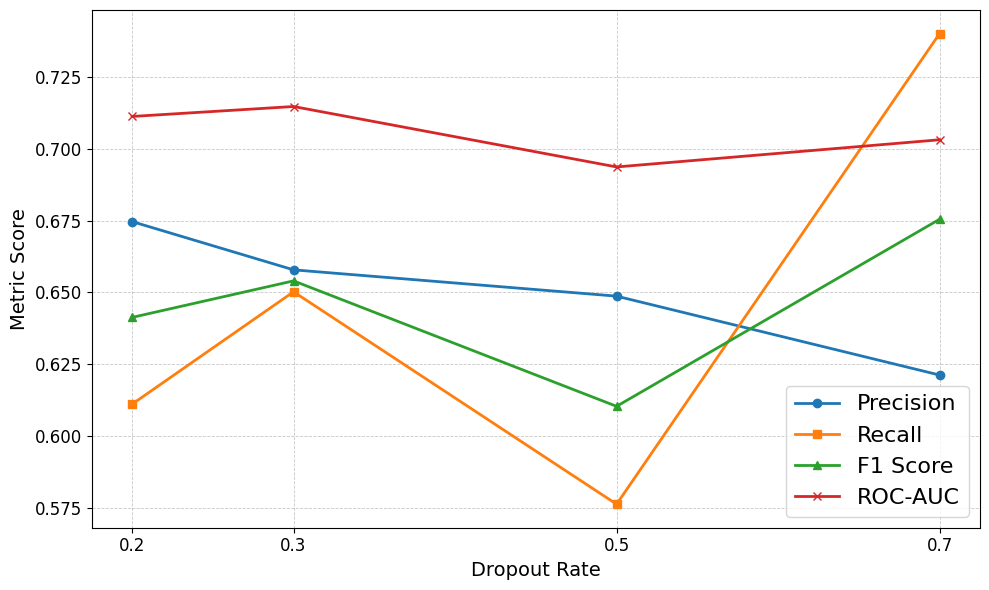

In [6]:
# ViT + MaxViT Hybrid (Performance VS Dropout Rate) - Chart

import matplotlib.pyplot as plt
import pandas as pd

# === Define Data ===
data = {
    'Dropout Rate': [0.2, 0.3, 0.5, 0.7],
    'Precision': [0.674679, 0.657856, 0.648693, 0.621194],
    'Recall': [0.611030, 0.650218, 0.576197, 0.740203],
    'F1 Score': [0.641280, 0.654015, 0.610300, 0.675497],
    'ROC-AUC': [0.711306, 0.714774, 0.693714, 0.703183]
}

df = pd.DataFrame(data)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(df['Dropout Rate'], df['Precision'], marker='o', label='Precision', linewidth=2)
plt.plot(df['Dropout Rate'], df['Recall'], marker='s', label='Recall', linewidth=2)
plt.plot(df['Dropout Rate'], df['F1 Score'], marker='^', label='F1 Score', linewidth=2)
plt.plot(df['Dropout Rate'], df['ROC-AUC'], marker='x', label='ROC-AUC', linewidth=2)

# === Styling for Journal ===
#plt.title('Model Performance vs Dropout Rate', fontsize=16, weight='bold')
plt.xlabel('Dropout Rate', fontsize=14)
plt.ylabel('Metric Score', fontsize=14)
plt.xticks(df['Dropout Rate'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
plt.legend(loc='lower right', fontsize=16)
plt.tight_layout()
plt.savefig("dropout_vs_performance.pdf", format='pdf', bbox_inches='tight')
plt.show()
